Class 0: binding protein
Class 1: discordant results
Class 2: general health
Class 3: healthy
Class 4: hyperthyroid conditions
Class 5: hypothyroid conditions
Class 6: other
Class 7: replacement therapy
                         precision    recall  f1-score   support

        binding protein       0.84      0.58      0.69        55
     discordant results       0.83      0.77      0.80        31
         general health       0.95      0.96      0.95        72
                healthy       0.97      0.98      0.97      1114
hyperthyroid conditions       0.71      0.68      0.69        25
 hypothyroid conditions       0.87      1.00      0.93        81
                  other       1.00      0.82      0.90        33
    replacement therapy       0.96      0.89      0.93        57

               accuracy                           0.95      1468
              macro avg       0.89      0.84      0.86      1468
           weighted avg       0.95      0.95      0.95      1468

              

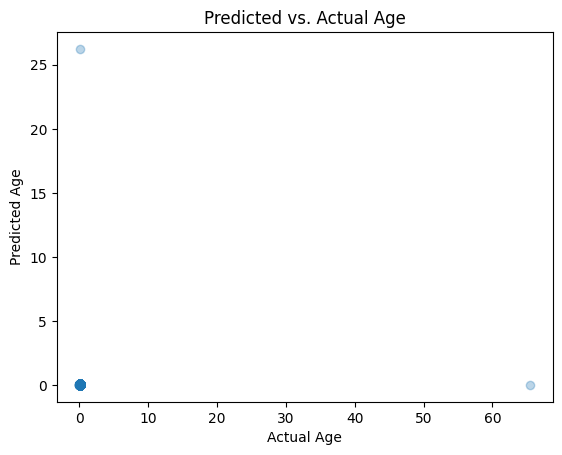

     Record Identification  Actual gender  Predicted sex
996            [841122082]              0              0
736            [850912062]              1              0
1244           [841127060]              0              0
1181           [840823010]              0              0
3393           [861121057]              0              0
...                    ...            ...            ...
705            [850423010]              1              0
5219           [860210066]              0              0
5407           [861119045]              0              0
4267           [850801049]              0              0
57             [840903010]              0              1

[1468 rows x 3 columns]
              precision    recall  f1-score   support

           F       0.75      0.84      0.79      1018
           M       0.48      0.38      0.42       410
         nan       1.00      0.07      0.14        40

    accuracy                           0.69      1468
   macro avg       

In [64]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error

# Load the data
data = pd.read_csv('proj-data.csv')

# Data preprocessing
# Remove trailing colons from column names
data.columns = data.columns.str.rstrip(':').str.strip()

# Replace non-numeric values with NaN
data.replace('?', np.nan, inplace=True)

# Handle binary columns
binary_columns = ['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured', 'TBG measured']
for col in binary_columns:
    data[col] = data[col].map({'f': 0, 't': 1})

# Convert appropriate columns to numeric
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Encode categorical variables
label_encoders = {}
categorical_columns = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
                       'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 
                       'goitre', 'tumor', 'hypopituitary', 'psych', 'referral source', 'diagnoses']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Preserve the record identification column
record_identification = data['[record identification]'].values

# Drop the record identification column from the main DataFrame
data.drop(columns=['[record identification]'], inplace=True)

# Ensure all data is numeric
#print(data.dtypes)

# Check for non-numeric data in the dataset
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Column {col} contains non-numeric values.")
        print(data[col].unique())

# Define the mapping for new classes
diagnosis_mapping = {
    '-': 'healthy',
    'A': 'hyperthyroid conditions', 'B': 'hyperthyroid conditions', 'C': 'hyperthyroid conditions', 'D': 'hyperthyroid conditions',
    'E': 'hypothyroid conditions', 'F': 'hypothyroid conditions', 'G': 'hypothyroid conditions', 'H': 'hypothyroid conditions',
    'I': 'binding protein', 'J': 'binding protein',
    'K': 'general health',
    'L': 'replacement therapy', 'M': 'replacement therapy', 'N': 'replacement therapy',
    'R': 'discordant results'
}

# Add remaining classes to 'other'
original_diagnoses_labels = label_encoders['diagnoses'].classes_
for label in original_diagnoses_labels:
    if label not in diagnosis_mapping:
        diagnosis_mapping[label] = 'other'

# Map the diagnoses to new classes
data['diagnoses'] = data['diagnoses'].map(lambda x: diagnosis_mapping[label_encoders['diagnoses'].inverse_transform([x])[0]])

# Encode the new class labels
label_encoders['diagnoses'] = LabelEncoder()
data['diagnoses'] = label_encoders['diagnoses'].fit_transform(data['diagnoses'])

# Diagnose prediction model
X_diagnosis = data.drop(['diagnoses'], axis=1)
y_diagnosis = data['diagnoses']

# Split data into training and testing sets for diagnosis prediction
X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

# Model training for diagnosis prediction
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_diag, y_train_diag)

# Model evaluation for diagnosis prediction
y_pred_diag = rf_classifier.predict(X_test_diag)

# Retrieve original class labels for diagnoses
new_diagnoses_labels = label_encoders['diagnoses'].classes_

# Print class labels and their corresponding diagnoses
for class_label, diagnosis in enumerate(new_diagnoses_labels):
    print(f"Class {class_label}: {diagnosis}")

print(classification_report(y_test_diag, y_pred_diag, target_names=new_diagnoses_labels))

# Feature importance for diagnosis prediction
importances_diag = rf_classifier.feature_importances_
feature_importance_df_diag = pd.DataFrame({'Feature': X_diagnosis.columns, 'Importance': importances_diag})
print(feature_importance_df_diag.sort_values(by='Importance', ascending=False))

# Age prediction model
X_age = data.drop(['age'], axis=1)
y_age = data['age']

# Split data into training and testing sets for age prediction
X_train_age, X_test_age, y_train_age, y_test_age, record_train, record_test = train_test_split(X_age, y_age, record_identification, test_size=0.2, random_state=42)

# Model training for age prediction
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_age, y_train_age)

# Age prediction evaluation
y_pred_age = rf_regressor.predict(X_test_age)

# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Record Identification': record_test, 'Actual Age': y_test_age, 'Predicted Age': y_pred_age})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_age, y_pred_age))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_age))
print('RMSE:', rmse)

print(classification_report(y_test_diag, y_pred_diag, target_names=new_diagnoses_labels))

# Feature importance for age prediction
importances_age = rf_regressor.feature_importances_
feature_importance_rf_age = pd.DataFrame({'Feature': X_age.columns, 'Importance': importances_age})
print(feature_importance_rf_age.sort_values(by='Importance', ascending=False))

# Plot predicted vs. actual ages
plt.scatter(y_test_age/1000, y_pred_age/1000, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs. Actual Age')
plt.show()

# Gender prediction model
X_gender = data.drop(['sex'], axis=1)
y_gender = data['sex']

# Split data into training and testing
X_train_gender, X_test_gender, y_train_gender, y_test_gender, record_train, record_test = train_test_split(X_gender, y_gender, record_identification, test_size=0.2, random_state=42)

# Model training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_gender, y_train_gender)

y_pred_gender = rf_classifier.predict(X_test_gender)

predictions2_df = pd.DataFrame({'Record Identification': record_test, 'Actual gender': y_test_gender, 'Predicted sex': y_pred_gender})
print(predictions2_df)

#accuracy = accuracy_score(y_test_gender, y_pred_gender)
#print('Accuracy:', accuracy)

print(classification_report(y_test_gender, y_pred_gender, target_names=label_encoders['sex'].classes_))


In [65]:
#------Importing Libraries------#
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error

In [66]:
#---------Data loading and preprocessing---------#

# Load the data
data = pd.read_csv('proj-data.csv')

# Data preprocessing
# Remove trailing colons from column names
data.columns = data.columns.str.rstrip(':').str.strip()

# Replace non-numeric values with NaN
data.replace('?', np.nan, inplace=True)

# Handle binary columns
binary_columns = ['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured', 'TBG measured']
for col in binary_columns:
    data[col] = data[col].map({'f': 0, 't': 1})

# Convert appropriate columns to numeric
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handle missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Encode categorical variables
label_encoders = {}
categorical_columns = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
                       'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 
                       'goitre', 'tumor', 'hypopituitary', 'psych', 'referral source', 'diagnoses']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Preserve the record identification column
record_identification = data['[record identification]'].values

# Drop the record identification column from the main DataFrame
data.drop(columns=['[record identification]'], inplace=True)

In [67]:
#--------Debugging--------#

# Ensure all data is numeric
#print(data.dtypes)

# Check for non-numeric data in the dataset
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Column {col} contains non-numeric values.")
        print(data[col].unique())

In [68]:
#----------Label Encoding and mapping----------#

# Define the mapping for new classes
diagnosis_mapping = {
    '-': 'healthy',
    'A': 'hyperthyroid conditions', 'B': 'hyperthyroid conditions', 'C': 'hyperthyroid conditions', 'D': 'hyperthyroid conditions',
    'E': 'hypothyroid conditions', 'F': 'hypothyroid conditions', 'G': 'hypothyroid conditions', 'H': 'hypothyroid conditions',
    'I': 'binding protein', 'J': 'binding protein',
    'K': 'general health',
    'L': 'replacement therapy', 'M': 'replacement therapy', 'N': 'replacement therapy',
    'R': 'discordant results'
}

# Add remaining classes to 'other'
original_diagnoses_labels = label_encoders['diagnoses'].classes_
for label in original_diagnoses_labels:
    if label not in diagnosis_mapping:
        diagnosis_mapping[label] = 'other'

# Map the diagnoses to new classes
data['diagnoses'] = data['diagnoses'].map(lambda x: diagnosis_mapping[label_encoders['diagnoses'].inverse_transform([x])[0]])

# Encode the new class labels
label_encoders['diagnoses'] = LabelEncoder()
data['diagnoses'] = label_encoders['diagnoses'].fit_transform(data['diagnoses'])

In [69]:
#--------Diagnose prediction model--------#

# Diagnose prediction model
X_diagnosis = data.drop(['diagnoses'], axis=1)
y_diagnosis = data['diagnoses']

# Split data into training and testing sets for diagnosis prediction
X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

# Model training for diagnosis prediction
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_diag, y_train_diag)

# Model evaluation for diagnosis prediction
y_pred_diag = rf_classifier.predict(X_test_diag)

# Retrieve original class labels for diagnoses
new_diagnoses_labels = label_encoders['diagnoses'].classes_

# Print class labels and their corresponding diagnoses
for class_label, diagnosis in enumerate(new_diagnoses_labels):
    print(f"Class {class_label}: {diagnosis}")

print(classification_report(y_test_diag, y_pred_diag, target_names=new_diagnoses_labels))

# Feature importance for diagnosis prediction
importances_diag = rf_classifier.feature_importances_
feature_importance_df_diag = pd.DataFrame({'Feature': X_diagnosis.columns, 'Importance': importances_diag})
print(feature_importance_df_diag.sort_values(by='Importance', ascending=False))

Class 0: binding protein
Class 1: discordant results
Class 2: general health
Class 3: healthy
Class 4: hyperthyroid conditions
Class 5: hypothyroid conditions
Class 6: other
Class 7: replacement therapy
                         precision    recall  f1-score   support

        binding protein       0.83      0.64      0.72        55
     discordant results       0.88      0.74      0.81        31
         general health       0.96      0.96      0.96        72
                healthy       0.97      0.98      0.98      1114
hyperthyroid conditions       0.76      0.64      0.70        25
 hypothyroid conditions       0.89      1.00      0.94        81
                  other       1.00      0.85      0.92        33
    replacement therapy       0.94      0.89      0.92        57

               accuracy                           0.95      1468
              macro avg       0.90      0.84      0.87      1468
           weighted avg       0.95      0.95      0.95      1468

              

     Record Identification  Actual Age  Predicted Age
996            [841122082]        34.0      63.045615
736            [850912062]        58.0      54.040000
1244           [841127060]        41.0      41.510000
1181           [840823010]        28.0      66.040000
3393           [861121057]        24.0      51.670000
...                    ...         ...            ...
705            [850423010]        72.0      39.470000
5219           [860210066]        79.0      54.390000
5407           [861119045]        77.0      61.490000
4267           [850801049]        69.0      54.268000
57             [840903010]        69.0      42.520000

[1468 rows x 3 columns]
MSE: 3165092.666863599
RMSE: 1779.0707312705695
                      Feature  Importance
22                        T4U    0.356168
16                        TSH    0.160318
24                        FTI    0.115628
18                         T3    0.093022
20                        TT4    0.087493
0                         s

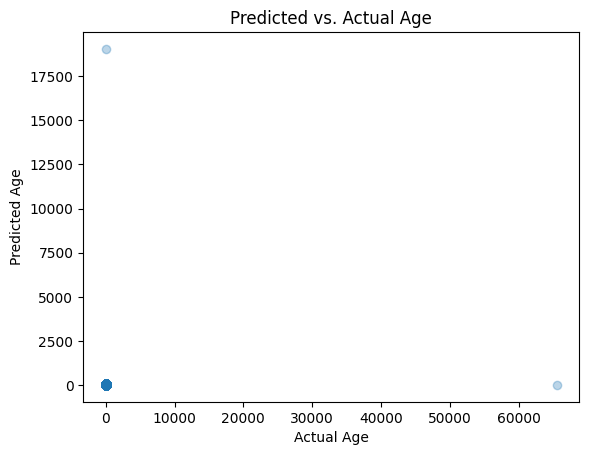

In [70]:
#---------Age prediction model---------#

# Age prediction model
X_age = data.drop(['age'], axis=1)
y_age = data['age']

# Split data into training and testing sets for age prediction
X_train_age, X_test_age, y_train_age, y_test_age, record_train, record_test = train_test_split(X_age, y_age, record_identification, test_size=0.2, random_state=42)

# Model training for age prediction
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_age, y_train_age)

# Age prediction evaluation
y_pred_age = rf_regressor.predict(X_test_age)

# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Record Identification': record_test, 'Actual Age': y_test_age, 'Predicted Age': y_pred_age})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_age, y_pred_age))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_age))
print('RMSE:', rmse)

# Feature importance for age prediction
importances_age = rf_regressor.feature_importances_
feature_importance_rf_age = pd.DataFrame({'Feature': X_age.columns, 'Importance': importances_age})
print(feature_importance_rf_age.sort_values(by='Importance', ascending=False))

# Plot predicted vs. actual ages
plt.scatter(y_test_age, y_pred_age, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs. Actual Age')
plt.show()

In [71]:
#---------Sex prediction model---------#

# Gender prediction model
X_gender = data.drop(['sex'], axis=1)
y_gender = data['sex']

# Split data into training and testing
X_train_gender, X_test_gender, y_train_gender, y_test_gender, record_train, record_test = train_test_split(X_gender, y_gender, record_identification, test_size=0.2, random_state=42)

# Model training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_gender, y_train_gender)

y_pred_gender = rf_classifier.predict(X_test_gender)

predictions2_df = pd.DataFrame({'Record Identification': record_test, 'Actual gender': y_test_gender, 'Predicted sex': y_pred_gender})
print(predictions2_df)

# Feature importance for sex prediction
importances_gender = rf_classifier.feature_importances_
feature_importance_rf_gender = pd.DataFrame({'Feature': X_gender.columns, 'Importance': importances_gender})
print(feature_importance_rf_gender.sort_values(by='Importance', ascending=False))

#accuracy = accuracy_score(y_test_gender, y_pred_gender)
#print('Accuracy:', accuracy)

print(classification_report(y_test_gender, y_pred_gender, target_names=label_encoders['sex'].classes_))

     Record Identification  Actual gender  Predicted sex
996            [841122082]              0              0
736            [850912062]              1              0
1244           [841127060]              0              0
1181           [840823010]              0              0
3393           [861121057]              0              0
...                    ...            ...            ...
705            [850423010]              1              0
5219           [860210066]              0              0
5407           [861119045]              0              0
4267           [850801049]              0              0
57             [840903010]              0              0

[1468 rows x 3 columns]
                      Feature  Importance
0                         age    0.151160
22                        T4U    0.146249
20                        TT4    0.141384
16                        TSH    0.133116
24                        FTI    0.128814
18                         T3    0.1003